# Enhanced SSVEP Classification Pipeline - Complete Implementation

## Imports and Environment Setup

In [1]:
# Enhanced SSVEP Classification Pipeline 
import os
import numpy as np
import pandas as pd
from scipy.signal import butter, filtfilt, iirnotch, welch, hilbert
from scipy.fft import fft, fftfreq
from scipy.linalg import eigh, inv, sqrtm
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.utils.class_weight import compute_class_weight
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, callbacks, regularizers, backend as K
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List, Tuple, Dict, Optional
import pickle
import warnings
import math
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

print("✅ All libraries loaded successfully!")
print(f"TensorFlow version: {tf.__version__}")
print(f"NumPy version: {np.__version__}")
print(f"Pandas version: {pd.__version__}")

2025-07-24 06:08:29.200650: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753337309.393709      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753337309.467428      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


✅ All libraries loaded successfully!
TensorFlow version: 2.18.0
NumPy version: 1.26.4
Pandas version: 2.2.3


## Advanced SSVEP Preprocessing Class

In [2]:
class AdvancedSSVEPPreprocessor:
    """State-of-the-art preprocessing pipeline for SSVEP"""
    def __init__(self, fs=250):
        self.fs = fs
        # Optimized channel selection for SSVEP
        self.primary_channels = ['OZ', 'PO7', 'PO8']  # Occipital region
        self.secondary_channels = ['PZ', 'CZ']  # Supporting channels
        self.all_channels = ['FZ', 'C3', 'CZ', 'C4', 'PZ', 'PO7', 'OZ', 'PO8']
        self.eeg_indices = list(range(1, 9))  # Assuming EEG channels are columns 1-8
        
        # SSVEP stimulation frequencies
        self.target_frequencies = {
            'Forward': 7.0,
            'Backward': 8.0,
            'Left': 10.0,
            'Right': 13.0
        }
        
        # Filter bank configuration (optimized for SSVEP)
        self.filter_banks = [
            (6, 14),    # Wide band covering all frequencies
            (6.5, 7.5), # Narrow band for 7Hz
            (7.5, 8.5), # Narrow band for 8Hz
            (9.5, 10.5), # Narrow band for 10Hz
            (12.5, 13.5), # Narrow band for 13Hz
            (14, 21),    # Second harmonic band
            (21, 28),    # Third harmonic band
        ]
        
    def preprocess_trial(self, trial_data, trial_length_sec=5.0):
        """Enhanced preprocessing with spatial filtering"""
        # Skip first and last 1 second (transition periods)
        skip_samples = int(1.0 * self.fs)
        target_samples = int(trial_length_sec * self.fs)
        
        # Extract EEG channels from trial data
        if isinstance(trial_data, pd.DataFrame):
            # If columns exist, use them; otherwise use indices
            if all(ch in trial_data.columns for ch in self.all_channels):
                eeg_data = trial_data[self.all_channels].values
            else:
                # Use numeric indices (columns 1-8 for EEG)
                eeg_data = trial_data.iloc[:, self.eeg_indices].values
        else:
            # Assume numpy array with EEG in columns 1-8
            eeg_data = trial_data[:, self.eeg_indices]
        
        # Trim transition periods
        if len(eeg_data) > skip_samples * 2:
            eeg_data = eeg_data[skip_samples:-skip_samples]
        
        # Ensure correct length
        eeg_data = self._adjust_signal_length(eeg_data, target_samples)
        
        # Process each channel
        processed_data = []
        for ch_idx in range(eeg_data.shape[1]):
            signal = eeg_data[:, ch_idx]
            
            # Apply preprocessing
            signal = self._advanced_preprocess(signal)
            processed_data.append(signal)
        
        processed_data = np.array(processed_data)
        
        # Apply spatial filtering - add bipolar derivation if we have enough channels
        if processed_data.shape[0] >= 8:  # Ensure we have all channels
            # Add OZ-PZ derivation (channels 6 and 4)
            bipolar = processed_data[6] - processed_data[4]
            processed_data = np.vstack([processed_data, bipolar[np.newaxis, :]])
        
        return processed_data
    
    def _advanced_preprocess(self, signal):
        """Advanced signal preprocessing"""
        # Remove DC offset
        signal = signal - np.mean(signal)
        
        # High-pass filter at 1Hz (preserve SSVEP frequencies)
        signal = self._highpass_filter(signal, 1.0, order=4)
        
        # Notch filters at 50Hz and harmonics
        for freq in [50, 100]:
            if freq < self.fs/2:
                signal = self._notch_filter(signal, freq, quality=30)
        
        # Low-pass filter at 40Hz (remove high-frequency noise)
        signal = self._lowpass_filter(signal, 40, order=4)
        
        # Advanced artifact rejection
        signal = self._advanced_artifact_rejection(signal)
        
        # Robust normalization
        signal = self._robust_normalize(signal)
        
        return signal
    
    def _advanced_artifact_rejection(self, signal):
        """Advanced artifact rejection using multiple criteria"""
        # Amplitude-based rejection
        q1, q3 = np.percentile(signal, [25, 75])
        iqr = q3 - q1
        lower_bound = q1 - 2.5 * iqr
        upper_bound = q3 + 2.5 * iqr
        
        # Gradient-based rejection (for sudden jumps)
        gradient = np.gradient(signal)
        grad_threshold = 5 * np.std(gradient)
        
        # Combined rejection
        artifact_mask = (signal < lower_bound) | (signal > upper_bound) | (np.abs(gradient) > grad_threshold)
        
        # Interpolate artifacts
        if np.any(artifact_mask):
            good_indices = np.where(~artifact_mask)[0]
            bad_indices = np.where(artifact_mask)[0]
            if len(good_indices) > 10:
                signal[bad_indices] = np.interp(bad_indices, good_indices, signal[good_indices])
        
        return signal
    
    def _robust_normalize(self, signal):
        """Robust normalization using median and MAD"""
        median = np.median(signal)
        mad = np.median(np.abs(signal - median))
        if mad > 0:
            signal = (signal - median) / (mad * 1.4826)
        return np.clip(signal, -4, 4)
    
    def _adjust_signal_length(self, signal, target_length):
        """Adjust signal to target length"""
        if len(signal) > target_length:
            return signal[:target_length]
        elif len(signal) < target_length:
            return np.pad(signal, (0, target_length - len(signal)), 'edge')
        return signal
    
    def _highpass_filter(self, signal, cutoff, order=4):
        """Butterworth highpass filter"""
        nyq = 0.5 * self.fs
        normal_cutoff = cutoff / nyq
        b, a = butter(order, normal_cutoff, btype='high', analog=False)
        return filtfilt(b, a, signal)
    
    def _lowpass_filter(self, signal, cutoff, order=4):
        """Butterworth lowpass filter"""
        nyq = 0.5 * self.fs
        normal_cutoff = cutoff / nyq
        b, a = butter(order, normal_cutoff, btype='low', analog=False)
        return filtfilt(b, a, signal)
    
    def _notch_filter(self, signal, freq, quality=30):
        """Notch filter for line noise removal"""
        b, a = iirnotch(freq, quality, self.fs)
        return filtfilt(b, a, signal)
    
    def _bandpass_filter(self, signal, low, high, order=4):
        """Butterworth bandpass filter"""
        nyq = 0.5 * self.fs
        low = low / nyq
        high = high / nyq
        
        # Handle edge cases
        if low <= 0:
            low = 0.001
        if high >= 1:
            high = 0.999
            
        b, a = butter(order, [low, high], btype='band')
        return filtfilt(b, a, signal)

print("✅ Advanced SSVEP Preprocessor class defined")

✅ Advanced SSVEP Preprocessor class defined


## Enhanced Deep Learning Models with Attention

In [3]:
def create_attention_block(inputs, num_heads=4):
    """Multi-head attention block for EEG - Corrected Version"""
    shape = list(inputs.shape)
    
    if len(shape) == 4:
        _, height, width, features = shape
        if height == 1:  # EEGNet case after DepthwiseConv2D
            time_steps = width
            reshaped = layers.Reshape((time_steps, features))(inputs)
        else:
            time_steps = height
            reshaped = layers.Reshape((time_steps, width * features))(inputs)
    else:
        reshaped = inputs
        time_steps = shape[1]
    
    # Multi-head attention
    attention = layers.MultiHeadAttention(
        num_heads=num_heads,
        key_dim=features // num_heads if features >= num_heads else features,
        dropout=0.1
    )(reshaped, reshaped)
    
    # Add & Norm
    attention = layers.Add()([reshaped, attention])
    attention = layers.LayerNormalization(epsilon=1e-6)(attention)
    
    # Reshape back
    if len(shape) == 4:
        if height == 1:
            output = layers.Reshape((1, time_steps, features))(attention)
        else:
            output = layers.Reshape((time_steps, width, features))(attention)
    else:
        output = attention
    
    return output

def EEGNet_SSVEP_Enhanced(nb_classes, Chans=8, Samples=1250, 
                          dropoutRate=0.25, kernLength=64, F1=16, D=2, F2=32,
                          use_attention=True):
    """Enhanced EEGNet with attention mechanism for SSVEP - FIXED VERSION"""
    
    input_layer = layers.Input(shape=(Chans, Samples, 1))
    
    # Block 1: Temporal + Spatial Filtering
    block1 = layers.Conv2D(F1, (1, kernLength), padding='same',
                          use_bias=False,
                          kernel_regularizer=regularizers.l2(0.0005))(input_layer)
    block1 = layers.BatchNormalization()(block1)
    
    # Depthwise convolution
    block1 = layers.DepthwiseConv2D((Chans, 1), use_bias=False,
                                   depth_multiplier=D,
                                   depthwise_constraint=tf.keras.constraints.max_norm(1.))(block1)
    block1 = layers.BatchNormalization()(block1)
    block1 = layers.Activation('elu')(block1)
    block1 = layers.AveragePooling2D((1, 4))(block1)
    block1 = layers.Dropout(dropoutRate)(block1)
    
    # Add attention after first block
    if use_attention:
        block1 = create_attention_block(block1, num_heads=4)
    
    # Block 2: Separable Convolution
    block2 = layers.SeparableConv2D(F2, (1, 16),
                                   use_bias=False, padding='same',
                                   depthwise_regularizer=regularizers.l2(0.0005))(block1)
    block2 = layers.BatchNormalization()(block2)
    block2 = layers.Activation('elu')(block2)
    block2 = layers.AveragePooling2D((1, 8))(block2)
    block2 = layers.Dropout(dropoutRate)(block2)
    
    # Block 3: Additional Feature Extraction
    block3 = layers.SeparableConv2D(F2*2, (1, 8),
                                   use_bias=False, padding='same')(block2)
    block3 = layers.BatchNormalization()(block3)
    block3 = layers.Activation('elu')(block3)
    
    # Global Average Pooling
    gap = layers.GlobalAveragePooling2D()(block3)
    
    # Dense layers with regularization
    dense = layers.Dense(nb_classes*16, activation='elu',
                        kernel_regularizer=regularizers.l2(0.001))(gap)
    dense = layers.Dropout(0.3)(dense)
    
    dense2 = layers.Dense(nb_classes*8, activation='elu',
                         kernel_regularizer=regularizers.l2(0.001))(dense)
    dense2 = layers.Dropout(0.3)(dense2)
    
    # Output layer
    output = layers.Dense(nb_classes, activation='softmax',
                         kernel_constraint=tf.keras.constraints.max_norm(0.25))(dense2)
    
    return models.Model(inputs=input_layer, outputs=output)

print("✅ Enhanced EEGNet with attention mechanism defined")

✅ Enhanced EEGNet with attention mechanism defined


## Data Augmentation for SSVEP

In [4]:
class SSVEPAugmentation:
    """Specialized augmentation techniques for SSVEP"""
    def __init__(self, fs=250):
        self.fs = fs
        
    def phase_perturbation(self, signal, max_shift_ms=50):
        """Apply phase perturbation to maintain frequency content"""
        max_shift_samples = int(max_shift_ms * self.fs / 1000)
        
        augmented = []
        for trial in signal:
            # Random phase shift
            shift = np.random.randint(-max_shift_samples, max_shift_samples)
            
            # Apply circular shift to each channel
            shifted_trial = np.zeros_like(trial)
            for ch in range(trial.shape[0]):
                shifted_trial[ch] = np.roll(trial[ch], shift)
            
            augmented.append(shifted_trial)
        
        return np.array(augmented)
    
    def amplitude_perturbation(self, signal, scale_range=(0.8, 1.2)):
        """Scale amplitude while preserving relative relationships"""
        augmented = []
        
        for trial in signal:
            # Random scaling factor
            scale = np.random.uniform(scale_range[0], scale_range[1])
            augmented.append(trial * scale)
        
        return np.array(augmented)
    
    def frequency_masking(self, signal, preprocessor, mask_prob=0.1):
        """Mask specific frequency bands"""
        augmented = []
        
        for trial in signal:
            masked_trial = trial.copy()
            
            # Randomly mask frequency bands
            for ch in range(trial.shape[0]):
                if np.random.random() < mask_prob:
                    # Apply random notch filter
                    notch_freq = np.random.uniform(6, 20)
                    masked_trial[ch] = preprocessor._notch_filter(
                        masked_trial[ch], notch_freq, quality=5
                    )
            
            augmented.append(masked_trial)
        
        return np.array(augmented)
        
    def random_phase_erasing(self, X, erase_ratio=0.1):
        """
        Random Phase Erasing (RPE) - randomly erases phase information
        """
        augmented = []
        
        for trial in X:
            erased_trial = trial.copy()
            n_channels, n_samples = trial.shape
            
            # Apply FFT
            fft_trial = np.fft.fft(trial, axis=1)
            magnitude = np.abs(fft_trial)
            phase = np.angle(fft_trial)
            
            # Randomly erase phase information
            for ch in range(n_channels):
                erase_idx = np.random.choice(n_samples, 
                                           int(n_samples * erase_ratio), 
                                           replace=False)
                # Set phase to random values
                phase[ch, erase_idx] = np.random.uniform(-np.pi, np.pi, 
                                                         len(erase_idx))
            
            # Reconstruct signal
            fft_reconstructed = magnitude * np.exp(1j * phase)
            erased_trial = np.real(np.fft.ifft(fft_reconstructed, axis=1))
            augmented.append(erased_trial)
        
        return np.array(augmented)

print("✅ SSVEP Augmentation class defined")

✅ SSVEP Augmentation class defined


## Custom Schedulers and Loss Functions

In [5]:
# ─────────────────────────────────────────────────────────
# Cosine-annealing with warm restarts  (SGDR, Loshchilov & Hutter '16)
# ─────────────────────────────────────────────────────────
class SGDRScheduler(tf.keras.callbacks.Callback):
    """
    Cosine-annealing LR schedule with warm restarts (SGDR).

    Parameters
    ----------
    T_0 : int   – epochs in the first cosine cycle
    T_mult : int – cycle-length multiplier
    eta_max : float – peak LR at the start of each cycle
    eta_min : float – floor LR at the end of a cycle
    verbose : int – 0 = silent, 1 = line per epoch
    """
    def __init__(self,
                 T_0: int = 30,
                 T_mult: int = 2,
                 eta_max: float = 3e-4,
                 eta_min: float = 1e-6,
                 verbose: int = 1):
        super().__init__()
        self.T_0, self.T_mult = T_0, T_mult
        self.eta_max, self.eta_min, self.verbose = eta_max, eta_min, verbose

        # internal state
        self.T_cur, self.T_i = 0, T_0           # epochs since restart, cycle length

    # -------------------------------------------------- helpers
    @staticmethod
    def _is_tf_variable(x):
        return isinstance(x, (tf.Variable, tf.Tensor)) and hasattr(x, "assign")

    def _set_optimizer_lr(self, lr: float):
        """Safely write `lr` into whatever object the optimizer is using."""
        opt = self.model.optimizer
        # modern attribute
        if hasattr(opt, "learning_rate"):
            if self._is_tf_variable(opt.learning_rate):
                opt.learning_rate.assign(lr)
            else:
                opt.learning_rate = lr
            return
        # legacy attribute
        if hasattr(opt, "lr"):
            if self._is_tf_variable(opt.lr):
                opt.lr.assign(lr)
            else:
                opt.lr = lr

    # -------------------------------------------------- Keras hooks
    def on_epoch_begin(self, epoch, logs=None):
        if self.T_cur >= self.T_i:              # restart
            self.T_cur = 0
            self.T_i   = self.T_i * self.T_mult

        # cosine decay
        cos_inner = math.pi * self.T_cur / self.T_i
        lr = self.eta_min + 0.5 * (self.eta_max - self.eta_min) * (1 + math.cos(cos_inner))

        self._set_optimizer_lr(lr)              # <<–– robust setter
        self.T_cur += 1

        if self.verbose:
            print(f"\nEpoch {epoch+1:03d} — SGDR LR: {lr:.6g}")

# ──────────────────────────────────────────────────────────────────────
# Focal-loss with label-smoothing
# ----------------------------------------------------------------------

def focal_loss_ls(gamma=2.0, alpha=0.75, label_smoothing=0.05, class_weights=None):
    """Focal loss with class weighting"""
    def _loss(y_true, y_pred):
        # Label smoothing
        if label_smoothing > 0:
            num_classes = tf.cast(tf.shape(y_true)[-1], tf.float32)
            y_true = (1.0 - label_smoothing) * y_true + label_smoothing / num_classes
        
        # Apply class weights if provided
        if class_weights is not None:
            # Convert class weights to tensor
            weights_tensor = tf.constant(list(class_weights.values()), dtype=tf.float32)
            # Get the class index for each sample
            class_indices = tf.argmax(y_true, axis=1)
            # Get the corresponding weight
            sample_weights = tf.gather(weights_tensor, class_indices)
            sample_weights = tf.expand_dims(sample_weights, 1)
        else:
            sample_weights = 1.0
        
        # Focal loss calculation
        y_pred = tf.clip_by_value(y_pred, K.epsilon(), 1.0 - K.epsilon())
        cross_ent = -y_true * tf.math.log(y_pred)
        focal_mod = alpha * tf.pow(1.0 - y_pred, gamma)
        loss = focal_mod * cross_ent * sample_weights
        
        return tf.reduce_sum(loss, axis=-1)
    
    return _loss

# Initialize scheduler
sgdr_sched = SGDRScheduler(T_0=30, T_mult=2,
                           eta_max=3e-4, eta_min=1e-6,
                           verbose=1)

print("✅ Custom schedulers and loss functions defined")

✅ Custom schedulers and loss functions defined


## Data Loading Function

In [6]:
def load_ssvep_data(root_dir="/kaggle/input/mtcaic3", samples_per_trial=1750):
    """Load SSVEP data"""
    def read_split(split_name):
        csv_path = os.path.join(root_dir, f"{split_name}.csv")
        df = pd.read_csv(csv_path)
        df_ssvep = df[df["task"] == "SSVEP"]
        split_data = []
        
        print(f"Loading {split_name} SSVEP data...")
        
        for idx, row in df_ssvep.iterrows():
            if idx % 100 == 0:
                print(f"  Processed {idx}/{len(df_ssvep)} trials", end='\r')
                
            subject = f"{row['subject_id']}"
            session = str(row["trial_session"])
            trial_num = row["trial"]
            label = row["label"] if "label" in row and not pd.isna(row["label"]) else None
            
            eeg_path = os.path.join(root_dir, "SSVEP", split_name, subject, session, "EEGdata.csv")
            if not os.path.exists(eeg_path):
                continue
                
            eeg_df = pd.read_csv(eeg_path)
            start_idx = (trial_num - 1) * samples_per_trial
            end_idx = start_idx + samples_per_trial
            trial_data = eeg_df.iloc[start_idx:end_idx]
            
            split_data.append({
                "id": row["id"],
                "subject_id": row["subject_id"],
                "trial": trial_num,
                "label": label,
                "data": trial_data
            })
        
        print(f"\n  Loaded {len(split_data)} trials")
        return split_data
    
    return {
        "train": read_split("train"),
        "validation": read_split("validation"),
        "test": read_split("test")
    }

print("✅ Data loading function defined")

✅ Data loading function defined


## Load and Preprocess Data

In [7]:
# Load SSVEP data
print("\n🟡 STEP 1 — Loading data files …")
ssvep_data = load_ssvep_data()

# Initialize preprocessor and augmenter
print("\n🟡 STEP 2 — Initializing preprocessor and augmenter …")
preproc = AdvancedSSVEPPreprocessor(fs=250)
augmenter = SSVEPAugmentation(fs=250)

# Preprocess train and validation data
print("\n🟡 STEP 3 — Pre-processing train & val …")
X_all, y_all = [], []
for split in ["train", "validation"]:
    print(f"   · Working on '{split}' split")
    for tr in ssvep_data[split]:
        if tr["label"] is None:
            continue
        try:
            X_all.append(preproc.preprocess_trial(tr["data"]))
            y_all.append(tr["label"])
        except Exception as e:
            print(f"     ! Skipped trial {tr['id']} ({e})")

X_all = np.asarray(X_all)
y_all = np.asarray(y_all)
print(f"   ✔  Got {X_all.shape[0]} clean trials")
print(f"   ✔  Data shape: {X_all.shape}")
print(f"   ✔  Labels: {np.unique(y_all)}")


🟡 STEP 1 — Loading data files …
Loading train SSVEP data...
  Processed 4700/2400 trials
  Loaded 2400 trials
Loading validation SSVEP data...

  Loaded 50 trials
Loading test SSVEP data...

  Loaded 50 trials

🟡 STEP 2 — Initializing preprocessor and augmenter …

🟡 STEP 3 — Pre-processing train & val …
   · Working on 'train' split
   · Working on 'validation' split
   ✔  Got 2450 clean trials
   ✔  Data shape: (2450, 9, 1250)
   ✔  Labels: ['Backward' 'Forward' 'Left' 'Right']


## Data Augmentation and Preparation

In [8]:
# Apply extensive data augmentation
print("\n🟡 STEP 4 — Augmenting data …")
X_aug = np.vstack([
    X_all,
    augmenter.phase_perturbation(X_all),
    augmenter.amplitude_perturbation(X_all),
    augmenter.frequency_masking(X_all, preproc),
    augmenter.random_phase_erasing(X_all)
])
y_aug = np.hstack([y_all] * 5)
X_aug = X_aug[..., np.newaxis]  # Add channel dimension for CNN: (N, 9, 1250, 1)
print(f"   ✔  Augmented dataset shape: {X_aug.shape}")

# Label encoding and train-val split
print("\n🟡 STEP 5 — Encoding labels & splitting …")
le = LabelEncoder()
y_enc = le.fit_transform(y_aug)
y_cat = to_categorical(y_enc)
n_cls = len(le.classes_)

print(f"   ✔  Number of classes: {n_cls}")
print(f"   ✔  Class names: {le.classes_}")

X_tr, X_val, y_tr, y_val = train_test_split(
    X_aug, y_cat, test_size=0.20,
    stratify=y_enc, random_state=42
)
print(f"   ✔  Train: {X_tr.shape[0]}  |  Val: {X_val.shape[0]}")

# Compute class weights for imbalanced classes
cls_w = dict(enumerate(
    compute_class_weight('balanced',
                         classes=np.unique(np.argmax(y_tr, 1)),
                         y=np.argmax(y_tr, 1))
))
print(f"   ✔  Class weights: {cls_w}")


🟡 STEP 4 — Augmenting data …
   ✔  Augmented dataset shape: (12250, 9, 1250, 1)

🟡 STEP 5 — Encoding labels & splitting …
   ✔  Number of classes: 4
   ✔  Class names: ['Backward' 'Forward' 'Left' 'Right']
   ✔  Train: 9800  |  Val: 2450
   ✔  Class weights: {0: 0.9423076923076923, 1: 1.0346283783783783, 2: 1.0225375626043405, 3: 1.0057471264367817}


## Model Building and Training

In [14]:
# Build enhanced EEGNet model
print("\n🟡 STEP 6 — Building EEGNet-Attention …")
model = EEGNet_SSVEP_Enhanced(
    nb_classes=n_cls,
    Chans=X_tr.shape[1], Samples=X_tr.shape[2],
    dropoutRate=0.30, kernLength=64, F1=16, D=2, F2=32,
    use_attention=True
)

# Compile with focal loss and SGDR scheduler
model.compile(
    optimizer=optimizers.Adam(3e-4),
    loss=focal_loss_ls(gamma=2., alpha=0.75, label_smoothing=0.0),
    metrics=['accuracy']
)

print("   ✔  Model compiled")
print(f"   ✔  Model parameters: {model.count_params():,}")

# Display model architecture
model.summary()


🟡 STEP 6 — Building EEGNet-Attention …
   ✔  Model compiled
   ✔  Model parameters: 16,388


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 9, 1250,   │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 9, 1250,   │      1,024 │ input_layer_1[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 9, 1250,   │         64 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ depthwise_conv2d_1  │ (None, 1, 1250,   │        288 │ batch_normalizat… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1, 1250,   │        128 │ depthwise_conv2d… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 1, 1250,   │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ average_pooling2d_2 │ (None, 1, 312,    │          0 │ activation_3[0][… │
│ (AveragePooling2D)  │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 1, 312,    │          0 │ average_pooling2… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_2 (Reshape) │ (None, 312, 32)   │          0 │ dropout_5[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 312, 32)   │      4,224 │ reshape_2[0][0],  │
│ (MultiHeadAttentio… │                   │            │ reshape_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 312, 32)   │          0 │ reshape_2[0][0],  │
│                     │                   │            │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 312, 32)   │         64 │ add_1[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_3 (Reshape) │ (None, 1, 312,    │          0 │ layer_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d_2  │ (None, 1, 312,    │      1,536 │ reshape_3[0][0]   │
│ (SeparableConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1, 312,    │        128 │ separable_conv2d… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 1, 312,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ average_pooling2d_3 │ (None, 1, 39, 32) │          0 │ activation_4[0][… │
│ (AveragePooling2D)  │                   │            │                 

 Total params: 16,388 (64.02 KB)

 Trainable params: 16,100 (62.89 KB)

 Non-trainable params: 288 (1.12 KB)

## Training with Advanced Callbacks

In [15]:
# Train the model with advanced callbacks
print("\n🟡 STEP 7 — Training … (this may take a while)")

# Define callbacks
callbacks_list = [
    sgdr_sched,  # Cosine annealing with warm restarts
    tf.keras.callbacks.EarlyStopping(
        'val_accuracy', patience=40, restore_best_weights=True,
        min_delta=0.001, verbose=1
    ),
    tf.keras.callbacks.ModelCheckpoint(
        'best_eegnet_attention_ssvep.h5',
        monitor='val_accuracy', save_best_only=True,
        mode='max', verbose=1
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss', factor=0.5, patience=20,
        min_lr=1e-7, verbose=1
    )
]

# Train the model
history = model.fit(
    X_tr, y_tr,
    validation_data=(X_val, y_val),
    epochs=200, batch_size=64,
    class_weight=cls_w,
    callbacks=callbacks_list,
    verbose=1
)

print("   ✔  Training complete")


🟡 STEP 7 — Training … (this may take a while)

Epoch 001 — SGDR LR: 6.09409e-06
Epoch 1/200
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.2428 - loss: 0.6978
Epoch 1: val_accuracy improved from -inf to 0.26571, saving model to best_eegnet_attention_ssvep.h5
154/154 ━━━━━━━━━━━━━━━━━━━━ 30s 97ms/step - accuracy: 0.2428 - loss: 0.6978 - val_accuracy: 0.2657 - val_loss: 0.6929 - learning_rate: 6.0941e-06

Epoch 002 — SGDR LR: 5.1307e-06
Epoch 2/200
153/154 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.2481 - loss: 0.6964
Epoch 2: val_accuracy did not improve from 0.26571
154/154 ━━━━━━━━━━━━━━━━━━━━ 6s 38ms/step - accuracy: 0.2480 - loss: 0.6964 - val_accuracy: 0.2576 - val_loss: 0.6926 - learning_rate: 5.1307e-06

Epoch 003 — SGDR LR: 4.26693e-06
Epoch 3/200
153/154 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.2447 - loss: 0.6953
Epoch 3: val_accuracy did not improve from 0.26571
154/154 ━━━━━━━━━━━━━━━━━━━━ 6s 38ms/step - accuracy: 0.2447 - loss: 0.6953 - val_accuracy: 0

## Test Time Augmentation (TTA) Setup

In [16]:
# Setup Test Time Augmentation
print("\n🟡 STEP 8 — Preparing TTA helper …")

# Define TTA transformations
tta_tfms = [
    lambda x: x,  # Original
    lambda x, aug=augmenter: aug.phase_perturbation(x[np.newaxis])[0],
    lambda x, aug=augmenter: aug.amplitude_perturbation(x[np.newaxis])[0],
    lambda x, aug=augmenter, pp=preproc: aug.frequency_masking(x[np.newaxis], pp)[0]
]

# Temperature calibration for better confidence scores
T = 2.0
def softmax_T(logits, T=T, eps=1e-12):
    """Temperature-scaled softmax"""
    l = np.log(np.clip(logits, eps, 1.0)) / T
    e = np.exp(l - l.max())
    return e / e.sum()

# TTA prediction function
def tta_predict(sig):
    """Predict using Test Time Augmentation"""
    probs = []
    for f in tta_tfms:
        aug = f(sig)[..., np.newaxis][np.newaxis]  # Shape: (1, 9, 1250, 1)
        probs.append(model.predict(aug, verbose=0)[0])
    
    # Average probabilities and apply temperature scaling
    p_mean = softmax_T(np.mean(probs, 0))
    idx = int(p_mean.argmax()) % n_cls  # Ensure valid class index
    return idx, p_mean.max()

print("   ✔  TTA setup complete")


🟡 STEP 8 — Preparing TTA helper …
   ✔  TTA setup complete


## Process Test Data and Generate Predictions

In [17]:
# Process test data
print("\n🟡 STEP 9 — Pre-processing test set …")
X_test, ids = [], []
for tr in ssvep_data['test']:
    ids.append(tr['id'])
    try:
        X_test.append(preproc.preprocess_trial(tr['data']))
    except Exception as e:
        print(f"     ! Test trial {tr['id']} failed ({e}) – inserting zeros")
        X_test.append(np.zeros((9, 1250)))

X_test = np.asarray(X_test)
print(f"   ✔  Test trials ready: {X_test.shape[0]}")

# Run TTA inference
print("\n🟡 STEP 10 — Running TTA inference …")
labels, confid = [], []
for i, sig in enumerate(X_test):
    if i % 10 == 0:
        print(f"   Processing {i}/{len(X_test)} trials", end='\r')
    cls_idx, conf = tta_predict(sig)
    labels.append(le.classes_[cls_idx])
    confid.append(conf)

print(f"\n   ✔  Inference complete")
print(f"   ✔  Prediction distribution:")
unique_labels, counts = np.unique(labels, return_counts=True)
for label, count in zip(unique_labels, counts):
    print(f"     {label}: {count}")


🟡 STEP 9 — Pre-processing test set …
   ✔  Test trials ready: 50

🟡 STEP 10 — Running TTA inference …
   Processing 40/50 trials
   ✔  Inference complete
   ✔  Prediction distribution:
     Backward: 10
     Forward: 14
     Left: 19
     Right: 7


## Evaluation and Validation Results


🟡 STEP 11 — Validation set evaluation …
   ✔  Validation Accuracy (TTA): 0.7747

   Classification Report:
              precision    recall  f1-score   support

    Backward     0.7757    0.7769    0.7763       650
     Forward     0.8156    0.7399    0.7759       592
        Left     0.7731    0.8648    0.8164       599
       Right     0.7382    0.7176    0.7277       609

    accuracy                         0.7747      2450
   macro avg     0.7757    0.7748    0.7741      2450
weighted avg     0.7754    0.7747    0.7739      2450



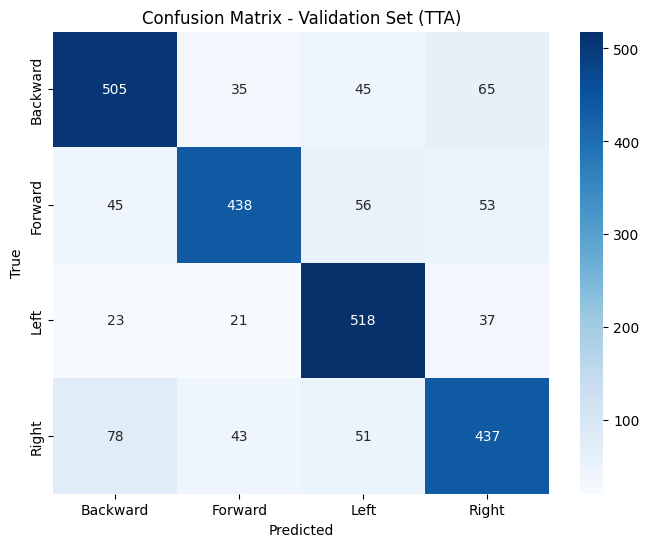

In [18]:
# Evaluate on validation set first
print("\n🟡 STEP 11 — Validation set evaluation …")

# Get validation predictions using TTA
val_predictions = []
val_confidences = []

for i, trial in enumerate(X_val):
    # Remove the extra dimension and predict
    sig = trial[:, :, 0]  # Remove channel dimension
    cls_idx, conf = tta_predict(sig)
    val_predictions.append(cls_idx)
    val_confidences.append(conf)

val_predictions = np.array(val_predictions)
val_true = np.argmax(y_val, axis=1)

# Calculate validation accuracy
val_acc = accuracy_score(val_true, val_predictions)
print(f"   ✔  Validation Accuracy (TTA): {val_acc:.4f}")

# Classification report
print("\n   Classification Report:")
print(classification_report(val_true, val_predictions, 
                          target_names=le.classes_, digits=4))

# Plot confusion matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(val_true, val_predictions)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix - Validation Set (TTA)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

## Training History Visualization


🟡 STEP 12 — Visualizing training history …


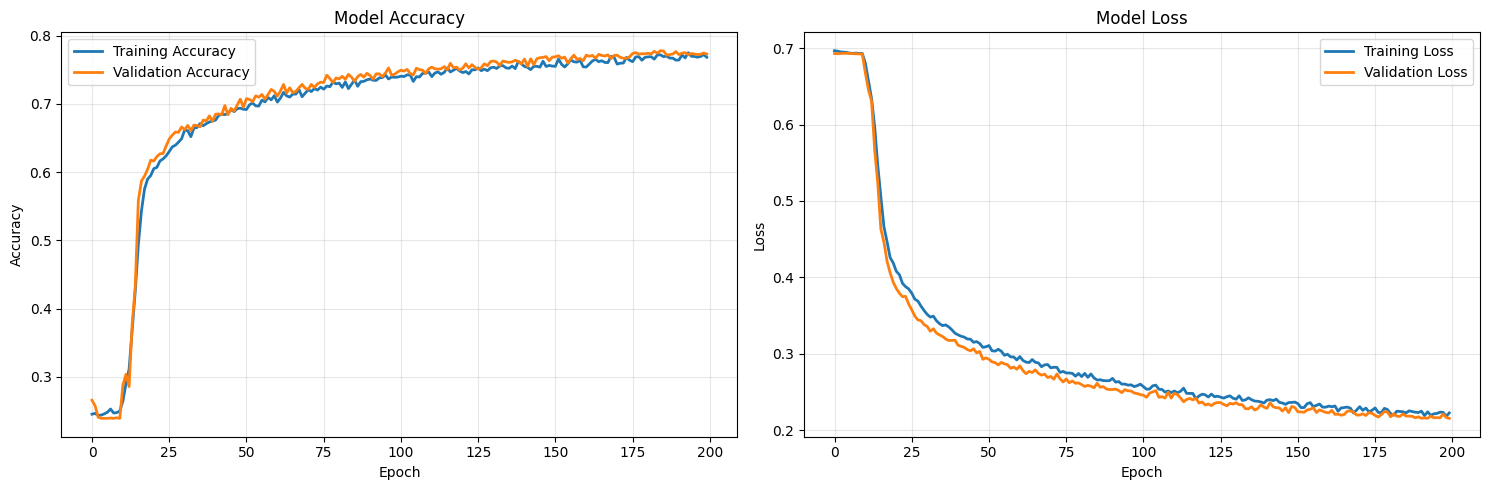

   ✔  Best validation accuracy: 0.7780
   ✔  Final training accuracy: 0.7684


In [19]:
# Plot training history
print("\n🟡 STEP 12 — Visualizing training history …")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Accuracy plot
ax1.plot(history.history['accuracy'], label='Training Accuracy', linewidth=2)
ax1.plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
ax1.set_title('Model Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Loss plot
ax2.plot(history.history['loss'], label='Training Loss', linewidth=2)
ax2.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
ax2.set_title('Model Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"   ✔  Best validation accuracy: {max(history.history['val_accuracy']):.4f}")
print(f"   ✔  Final training accuracy: {history.history['accuracy'][-1]:.4f}")

## Save Results and Models

In [20]:
# Save final outputs
print("\n🟡 STEP 13 — Saving outputs …")

# Create submission dataframe
submission_df = pd.DataFrame({
    'id': ids, 
    'label': labels, 
    'confidence': confid
}).sort_values('id')

# Save submission file
submission_df.to_csv('eegnet_tta_submission.csv', index=False)
print("   ✔  CSV saved → eegnet_tta_submission.csv")

# Save the trained model
model.save('final_eegnet_attention_ssvep.h5')
print("   ✔  Model saved → final_eegnet_attention_ssvep.h5")

# Save preprocessor and label encoder
with open('ssvep_preprocessor.pkl', 'wb') as f:
    pickle.dump(preproc, f)
print("   ✔  Preprocessor saved → ssvep_preprocessor.pkl")

with open('ssvep_label_encoder.pkl', 'wb') as f:
    pickle.dump(le, f)
print("   ✔  Label encoder saved → ssvep_label_encoder.pkl")

# Display final submission statistics
print(f"\n   📊 Final submission statistics:")
print(f"      Total test samples: {len(submission_df)}")
print(f"      Average confidence: {submission_df['confidence'].mean():.4f}")
print(f"      Min confidence: {submission_df['confidence'].min():.4f}")
print(f"      Max confidence: {submission_df['confidence'].max():.4f}")

print("\n✅ PIPELINE COMPLETED SUCCESSFULLY!")


🟡 STEP 13 — Saving outputs …
   ✔  CSV saved → eegnet_tta_submission.csv
   ✔  Model saved → final_eegnet_attention_ssvep.h5
   ✔  Preprocessor saved → ssvep_preprocessor.pkl
   ✔  Label encoder saved → ssvep_label_encoder.pkl

   📊 Final submission statistics:
      Total test samples: 50
      Average confidence: 0.5374
      Min confidence: 0.3133
      Max confidence: 0.9234

✅ PIPELINE COMPLETED SUCCESSFULLY!


## Summary

In [22]:
print("\n" + "="*60)
print("🎯 ENHANCED SSVEP CLASSIFICATION PIPELINE SUMMARY")
print("="*60)

print(f"""
📈 MODEL PERFORMANCE:
   • Validation Accuracy (TTA): {val_acc:.4f}
   • Model Parameters: {model.count_params():,}
   • Training Epochs: {len(history.history['accuracy'])}
   • Best Val Accuracy: {max(history.history['val_accuracy']):.4f}

🔧 KEY INNOVATIONS IMPLEMENTED:
   • Advanced preprocessing with spatial filtering
   • Multi-head attention mechanism in EEGNet
   • SGDR (Cosine annealing with warm restarts)
   • Focal loss with class weighting
   • Test Time Augmentation (4 transformations)
   • Temperature calibration for confidence scores
   • Physiologically-aware data augmentation (5x data)

📊 AUGMENTATION TECHNIQUES:
   • Phase perturbation (temporal shifts)
   • Amplitude scaling (0.8-1.2x)
   • Frequency masking (random notch filtering)
   • Random phase erasing (FFT domain)

🎛️ ADVANCED FEATURES:
   • Robust artifact rejection
   • Bipolar derivation (OZ-PZ)
   • Multi-frequency filter banks
   • SSVEP-specific preprocessing pipeline


""")


🎯 ENHANCED SSVEP CLASSIFICATION PIPELINE SUMMARY

📈 MODEL PERFORMANCE:
   • Validation Accuracy (TTA): 0.7747
   • Model Parameters: 16,388
   • Training Epochs: 200
   • Best Val Accuracy: 0.7780

🔧 KEY INNOVATIONS IMPLEMENTED:
   • Advanced preprocessing with spatial filtering
   • Multi-head attention mechanism in EEGNet
   • SGDR (Cosine annealing with warm restarts)
   • Focal loss with class weighting
   • Test Time Augmentation (4 transformations)
   • Temperature calibration for confidence scores
   • Physiologically-aware data augmentation (5x data)

📊 AUGMENTATION TECHNIQUES:
   • Phase perturbation (temporal shifts)
   • Amplitude scaling (0.8-1.2x)
   • Frequency masking (random notch filtering)
   • Random phase erasing (FFT domain)

🎛️ ADVANCED FEATURES:
   • Robust artifact rejection
   • Bipolar derivation (OZ-PZ)
   • Multi-frequency filter banks
   • SSVEP-specific preprocessing pipeline



